# 1. LIBRERÍAS

In [ ]:
#Tratamiento de datos
import pandas as pd
import numpy as np

#Análisis gráfico
import seaborn as sns
import matplotlib.pyplot as plt

#Modelado
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# 2. LECTURA DE DATOS

In [ ]:
#Rutas de los datos
r1='https://nequi-open-data.s3.amazonaws.com/sample_data_0006_part_00.parquet'
r2='https://nequi-open-data.s3.amazonaws.com/sample_data_0007_part_00.parquet'

In [ ]:
#Lectura dataframe 1
df1=pd.read_parquet(r1)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10758418 entries, 0 to 10758417
Data columns (total 8 columns):
 #   Column              Dtype         
---  ------              -----         
 0   merchant_id         object        
 1   _id                 object        
 2   subsidiary          object        
 3   transaction_date    datetime64[ns]
 4   account_number      object        
 5   user_id             object        
 6   transaction_amount  object        
 7   transaction_type    object        
dtypes: datetime64[ns](1), object(7)
memory usage: 656.6+ MB


In [ ]:
#Lectura dataframe 2
df2=pd.read_parquet(r2)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10758500 entries, 0 to 10758499
Data columns (total 8 columns):
 #   Column              Dtype         
---  ------              -----         
 0   merchant_id         object        
 1   _id                 object        
 2   subsidiary          object        
 3   transaction_date    datetime64[ns]
 4   account_number      object        
 5   user_id             object        
 6   transaction_amount  object        
 7   transaction_type    object        
dtypes: datetime64[ns](1), object(7)
memory usage: 656.6+ MB


In [ ]:
#Unión de los dataframes
df=pd.DataFrame()
df=pd.concat([df1,df2])
df=df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21516918 entries, 0 to 21516917
Data columns (total 8 columns):
 #   Column              Dtype         
---  ------              -----         
 0   merchant_id         object        
 1   _id                 object        
 2   subsidiary          object        
 3   transaction_date    datetime64[ns]
 4   account_number      object        
 5   user_id             object        
 6   transaction_amount  object        
 7   transaction_type    object        
dtypes: datetime64[ns](1), object(7)
memory usage: 1.3+ GB


In [ ]:
#Se borran datos de dataframes iniciales para liberar memoria
df1=[]
df2=[]

# 3. ANÁLISIS DE DATOS

## 3.1. Limpieza y tratamiento de datos

In [ ]:
#Comprobación datos nulos
df.isnull().sum()

merchant_id           0
_id                   0
subsidiary            0
transaction_date      0
account_number        0
user_id               0
transaction_amount    0
transaction_type      0
dtype: int64

In [ ]:
#Comprobación filas repetidas
df.duplicated().sum()

11

In [ ]:
#Se eliminan los duplicados
df=df.drop_duplicates()

In [ ]:
#Se transforma la columna de transaction_amount a tipo numérico
df['transaction_amount']=df['transaction_amount'].astype('float')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21516907 entries, 0 to 21516917
Data columns (total 8 columns):
 #   Column              Dtype         
---  ------              -----         
 0   merchant_id         object        
 1   _id                 object        
 2   subsidiary          object        
 3   transaction_date    datetime64[ns]
 4   account_number      object        
 5   user_id             object        
 6   transaction_amount  float64       
 7   transaction_type    object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 1.4+ GB


## 3.2. Descripción de los datos

In [ ]:
#Descripción básica de los datos
print('---------- Descripción monto transacciones ----------')
print(df.describe())
print('\n---------- Descripción fechas transacciones ----------')
print('Fecha mínima: ', df['transaction_date'].min(), ' Fecha máxima: ', df['transaction_date'].max())

---------- Descripción monto transacciones ----------
       transaction_amount
count        2.151691e+07
mean         1.912898e+02
std          2.408464e+02
min          5.944455e+00
25%          3.566673e+01
50%          1.070002e+02
75%          2.377782e+02
max          4.624786e+03

---------- Descripción fechas transacciones ----------
Fecha mínima:  2021-01-01 00:00:40  Fecha máxima:  2021-11-30 23:59:49


La base de datos tiene transacciones desde enero de 2021 hasta noviembre del mismo año. Los montos de las transacciones van entre 5.9 pesos hasta los 4,625 pesos aproxiamadamente.

In [ ]:
#Registros únicos por columna
df.nunique()

merchant_id                  3
_id                   21516901
subsidiary               16833
transaction_date      11735502
account_number         3099711
user_id                3087217
transaction_amount       28260
transaction_type             2
dtype: int64

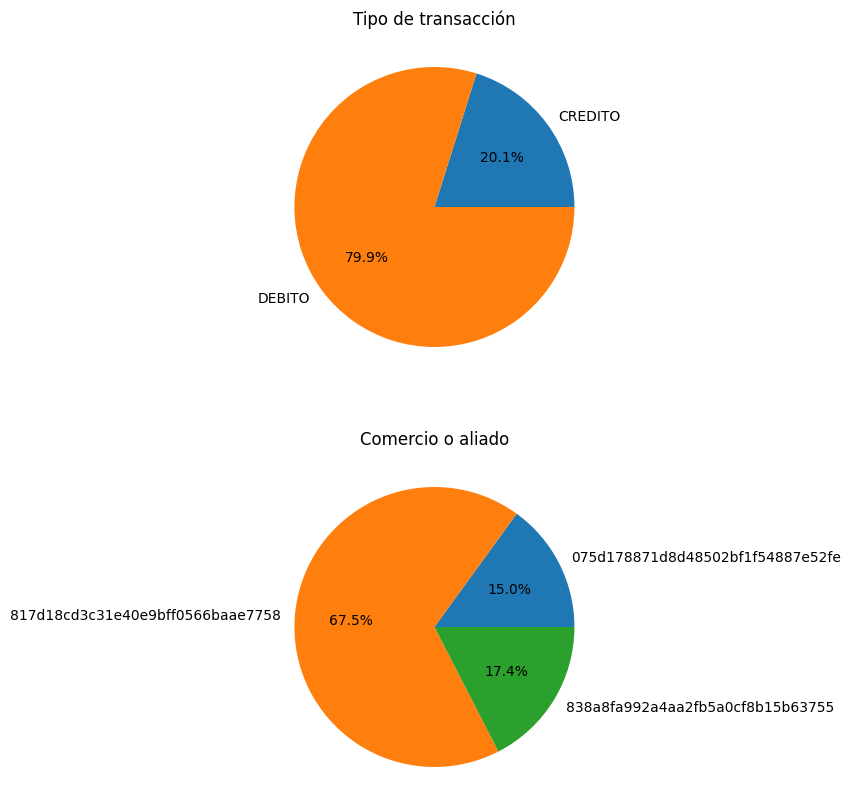

In [ ]:
#Distribución de los datos de transaction_type y merchant_id
fig,ax=plt.subplots(2,1,figsize=(10,10))

t_type=df[['_id','transaction_type']].groupby(['transaction_type'],
                                       as_index=False).count().rename(columns={'_id':'registros'})

merchant=df[['_id','merchant_id']].groupby(['merchant_id'],
                                       as_index=False).count().rename(columns={'_id':'registros'})

ax[0].pie(x=t_type['registros'], labels=t_type['transaction_type'].tolist(), autopct='%1.1f%%')
ax[0].set_title('Tipo de transacción')

ax[1].pie(x=merchant['registros'], labels=merchant['merchant_id'].tolist(), autopct='%1.1f%%')
ax[1].set_title('Comercio o aliado')

plt.show()

El 80% de las transacciones corresponden a tipo débito, en este caso, se eliminarán las transacciones crédito ya que solo nos interesan las débito. En cuanto al comercio, el 67% corresponde a 817d18cd3c31e40e9bff0566baae7758.

In [ ]:
#Se eliminan los registros de crédito
df=df[df['transaction_type']=='DEBITO'].reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17183727 entries, 0 to 17183726
Data columns (total 8 columns):
 #   Column              Dtype         
---  ------              -----         
 0   merchant_id         object        
 1   _id                 object        
 2   subsidiary          object        
 3   transaction_date    datetime64[ns]
 4   account_number      object        
 5   user_id             object        
 6   transaction_amount  float64       
 7   transaction_type    object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 1.0+ GB


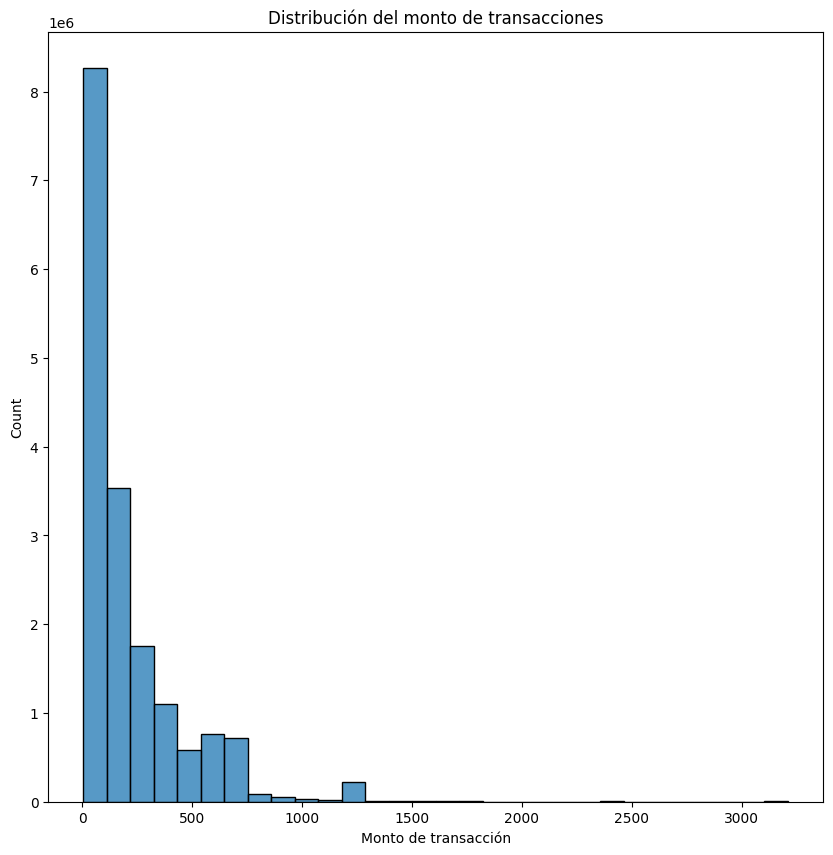

In [ ]:
#Distribución de las transacciones
plt.figure(figsize=(10,10))
sns.histplot(data=df, x='transaction_amount', bins=30)
plt.title('Distribución del monto de transacciones')
plt.xlabel('Monto de transacción')
plt.show()

Los montos de las transacciones se concentran entre 0 y 700 pesos aproximadamente, las transacciones mayores a 1,000 son poco frecuentes. Hay una alta concentración en montos bajos entre 0 y 200 pesos.

In [ ]:
#Usuarios y cuentas con mayor número de transacciones
df[['user_id','account_number','transaction_amount']].groupby(['user_id','account_number'],
                                                    as_index=False).count().sort_values(by=['transaction_amount'],
                                                                                        ascending=False).rename(columns={
                                                                                            'transaction_amount':'transacciones'
                                                                                        }).head(20)

,user_id,account_number,transacciones
39855,0457e033945b37b94d7f396aa07daaa1,171228ac3ecfa6c797a2ac382f22fc93,1762
1222595,84d55acc72d398e26fc939d06d17fdb4,bb43344022157cba434a58a212ed053f,1400
1360126,93bb7c11b0b58e233f56f50cd70c1a82,3094e023b7a40245397e116bddbe45e8,1393
1176906,7fda354dbc3e684bf414d3ab27208d79,01f215b451a797d8d42c1e5ee26edf82,1073
2088665,e2d6158cc2b6467a47223cb2629f03f3,bbd2d9cbfd4a10fc3963c4094554315d,1017
664176,483525c557cb54274c1a68438e0ebe45,4e6ec6ba5dfe817108182b70ba57420e,1000
1459515,9e925b3e2159cc6d6a4b33ab0a354748,f53495dc604acd80a66c44448467cf32,1000
1887712,cd15ab893db3f4ee8c43de00e2c42e51,852cf5a196377c39ccc34bfd80faf9b3,941
21444,025884337f6fe6a70fbb35c58fd798ed,db14b540a6f281bf032d6ddfe0282e4f,926
882798,5fef5527eacc09d4d1d332dfdcdf4a7b,5681310dfe339d882576655c222c90d5,801


El usuario 0457e033945b37b94d7f396aa07daaa1 tiene un total de 1,762 transacciones a la cuenta 171228ac3ecfa6c797a2ac382f22fc93. Se observan usuarios con una alta transaccionalidad a una única cuenta.

## 3.3. Transformación de datos

Se hará una transformación en los datos con el fin de conocer el número de transacciones y el monto total de estas que hacen los usuarios a las diferentes cuentas en un lapso de 24 horas.

In [ ]:
#Crea una nueva columna 'transaction_day' que contenga solo la fecha
df['transaction_day']=df['transaction_date'].dt.date

#Agrupa por 'transaction_day', 'user_id' y 'account_number' y calcula el número de transacciones, el promedio de cada transacción, la desviación de las transacciones y el valor total de las transacciones
df_agrupado=df.groupby(['transaction_day', 'user_id',
                          'account_number'])['transaction_amount'].agg(['count', 'mean',
                                                                        'std', 'sum']).reset_index()

#Renombra las columnas de las métricas
df_agrupado=df_agrupado.rename(columns={'count': 'num_transactions',
                                          'mean': 'mean_transaction_amount',
                                          'std': 'std_transaction_amount',
                                          'sum': 'total_transaction_amount'})
df_agrupado.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14989309 entries, 0 to 14989308
Data columns (total 7 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   transaction_day           object 
 1   user_id                   object 
 2   account_number            object 
 3   num_transactions          int64  
 4   mean_transaction_amount   float64
 5   std_transaction_amount    float64
 6   total_transaction_amount  float64
dtypes: float64(3), int64(1), object(3)
memory usage: 800.5+ MB


## 3.4. Descripción datos transformados

In [ ]:
#Descripción de los datos agrupados
df_agrupado.describe()

,num_transactions,mean_transaction_amount,std_transaction_amount,total_transaction_amount
count,1.498931e+07,1.498931e+07,1.509321e+06,1.498931e+07
mean,1.146399e+00,1.969453e+02,1.361351e+02,2.347372e+02
std,1.325830e+00,2.361395e+02,1.700293e+02,3.427633e+02
min,1.000000e+00,5.944455e+00,0.000000e+00,5.944455e+00
25%,1.000000e+00,4.993342e+01,8.406729e+00,5.944455e+01
50%,1.000000e+00,1.188891e+02,6.725383e+01,1.188891e+02
75%,1.000000e+00,2.377782e+02,2.108955e+02,2.615560e+02
max,2.000000e+02,3.210006e+03,2.244597e+03,1.569336e+04


El número de transacciones diarias por cuenta tiene un promedio de 1.14, es decir, la mayoría de usuarios solo hacen una transacción al día a una cuenta, sin embargo, se observa que el máximo llega hasta 200 transacciones en un mismo día a una cuenta, por tanto, se deben revisar estos datos atípicos.

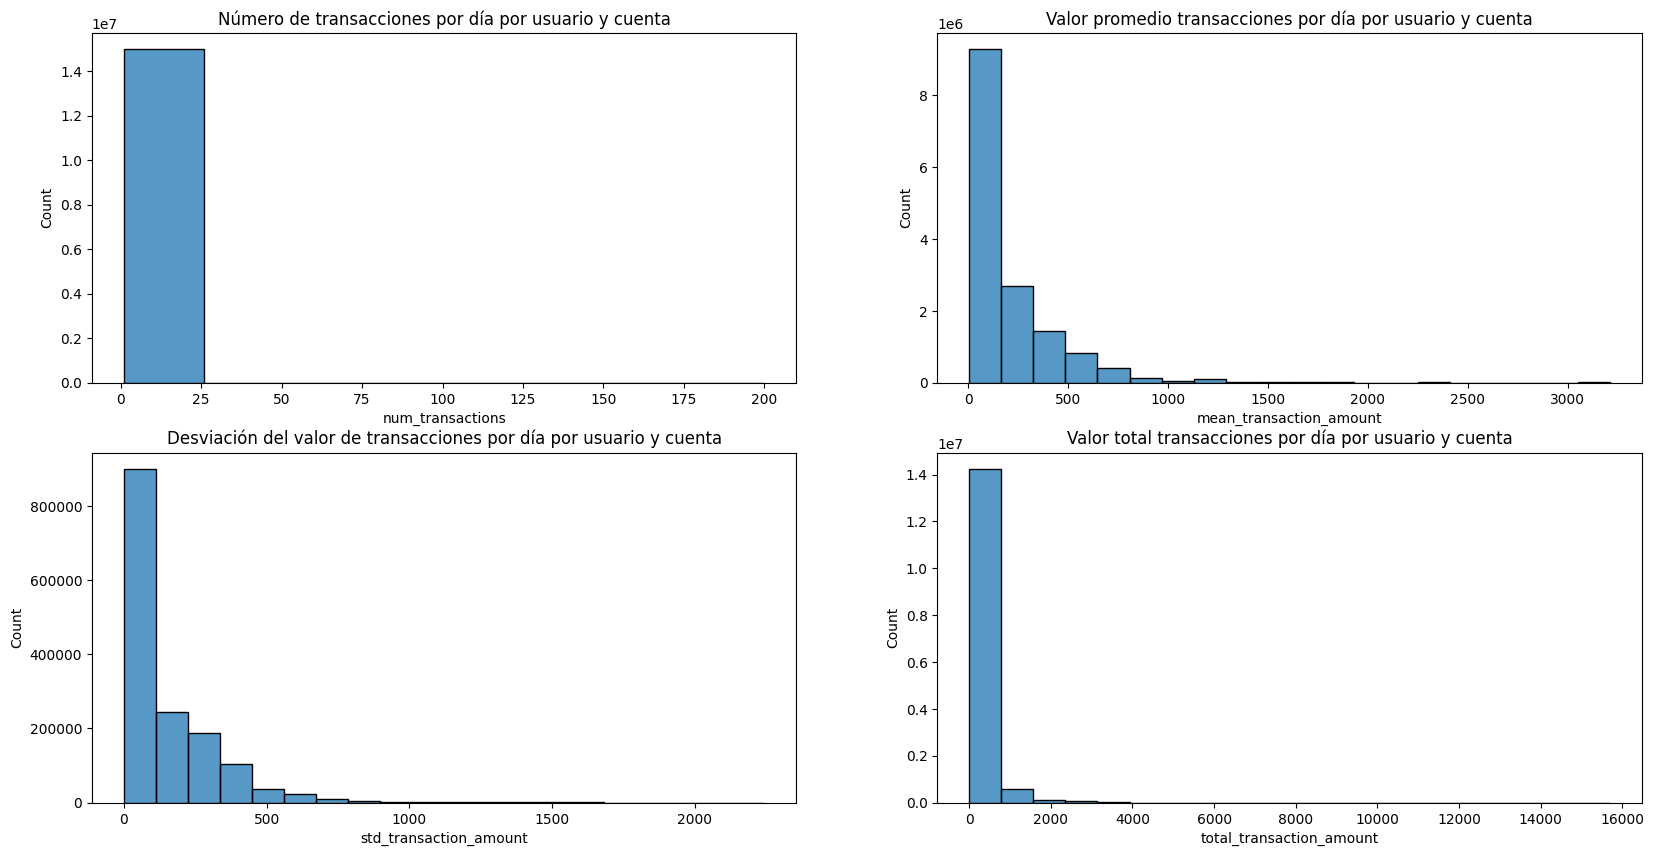

In [ ]:
#Distribución de las variables
fig, ax=plt.subplots(2,2,figsize=(20,10))

sns.histplot(data=df_agrupado, x='num_transactions', bins=8, ax=ax[0,0])
ax[0,0].set_title('Número de transacciones por día por usuario y cuenta')

sns.histplot(data=df_agrupado, x='mean_transaction_amount', bins=20, ax=ax[0,1])
ax[0,1].set_title('Valor promedio transacciones por día por usuario y cuenta')

sns.histplot(data=df_agrupado, x='std_transaction_amount', bins=20, ax=ax[1,0])
ax[1,0].set_title('Desviación del valor de transacciones por día por usuario y cuenta')

sns.histplot(data=df_agrupado, x='total_transaction_amount', bins=20, ax=ax[1,1])
ax[1,1].set_title('Valor total transacciones por día por usuario y cuenta')

plt.show()

Se observa que el número de transacciones por día, usuario y cuenta se concentra entre 0 y 25 transacciones, sin embargo, sabemos que el rango va hasta las 200 transacciones. Se debe buscar una visualización que refleje el comportamiento.

Por otra parte, se ve un comportamiento concentrado entre 0 y 500 para el valor promedio de transacciones, mismo rango de concentración para la desviación estándar entre estas transacciones, lo cual sugiere un alto coeficiente de varación en el valor de las transacciones hechas en un mismo día por un usuario a una misma cuenta.

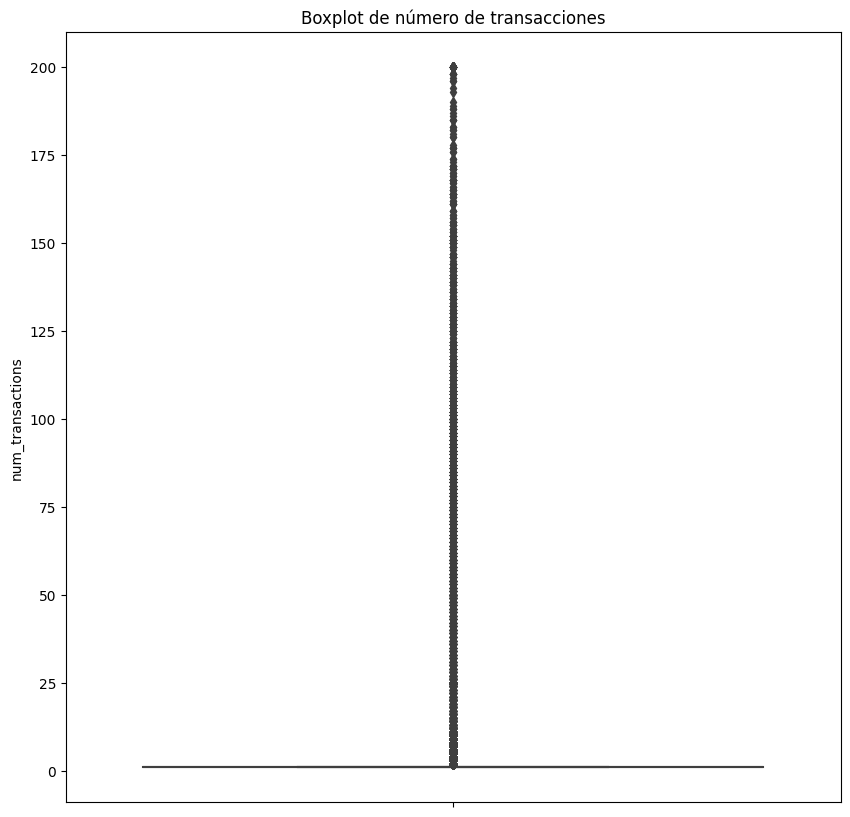

In [ ]:
#Boxplot de número de transacciones
plt.figure(figsize=(10,10))
sns.boxplot(data=df_agrupado, y='num_transactions')
plt.title('Boxplot de número de transacciones')
plt.show()

Dado el gran número de valores atípicos, en este boxplot no se alcanza a ver la caja del gráfico, sin embargo, se observa que transacciones por encima de 1 o 2 al día a la misma cuenta se puede tratar como un outlier.

In [ ]:
#Se reemplazan las desviaciones nulas por 0
df_agrupado=df_agrupado.fillna(0)

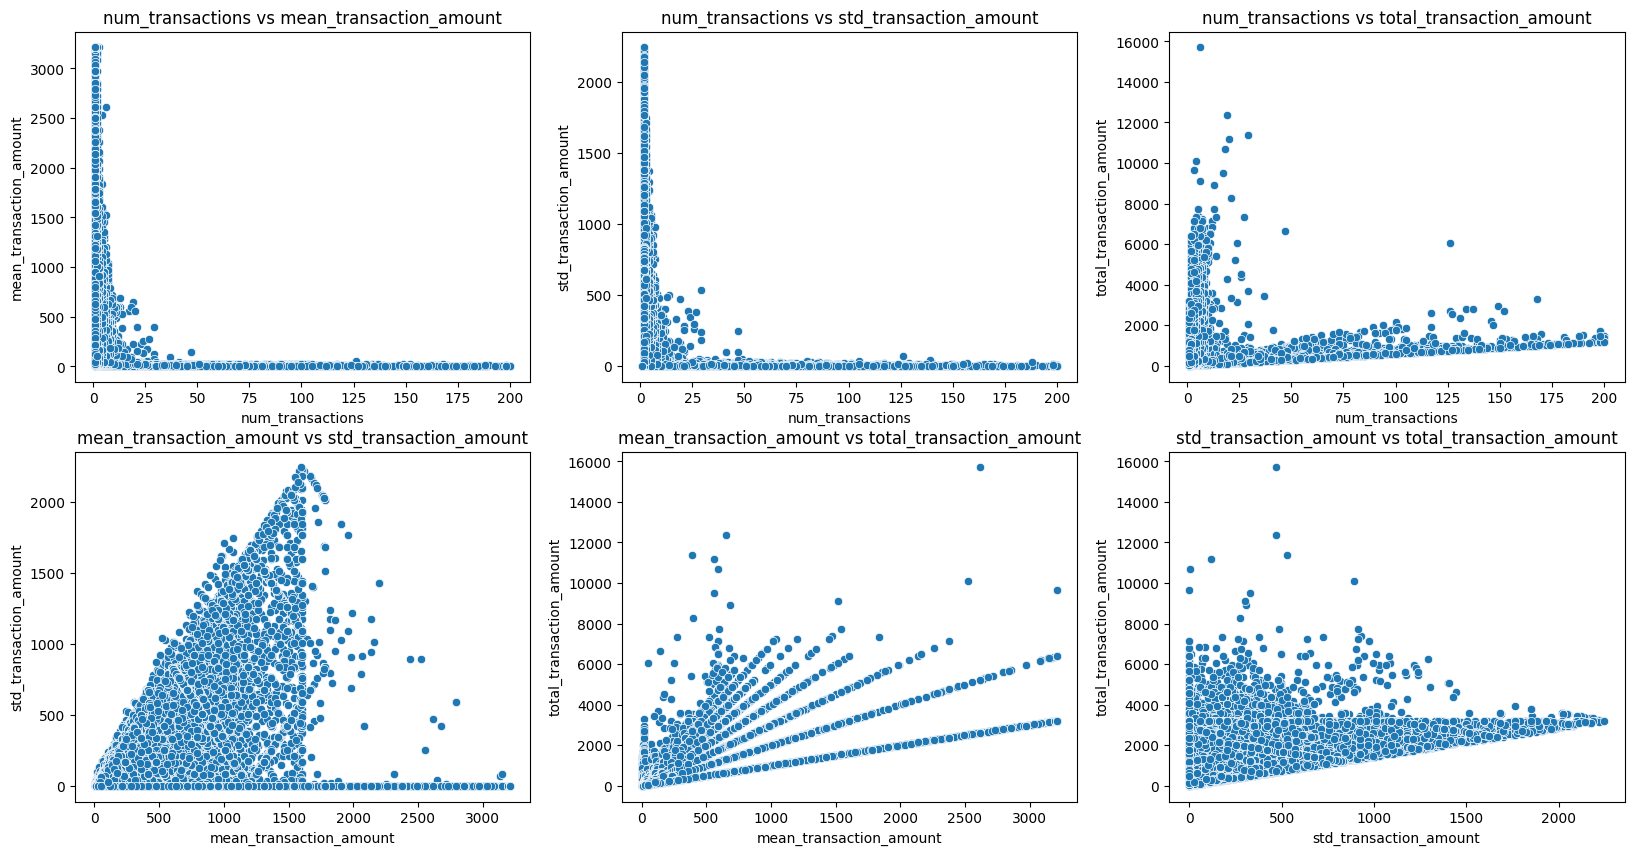

In [ ]:
#Relación entre variables

fig, ax=plt.subplots(2,3,figsize=(20,10))

sns.scatterplot(data=df_agrupado, x='num_transactions', y='mean_transaction_amount', ax=ax[0,0])
ax[0,0].set_title('num_transactions vs mean_transaction_amount')

sns.scatterplot(data=df_agrupado, x='num_transactions', y='std_transaction_amount', ax=ax[0,1])
ax[0,1].set_title('num_transactions vs std_transaction_amount')

sns.scatterplot(data=df_agrupado, x='num_transactions', y='total_transaction_amount', ax=ax[0,2])
ax[0,2].set_title('num_transactions vs total_transaction_amount')

sns.scatterplot(data=df_agrupado, x='mean_transaction_amount', y='std_transaction_amount', ax=ax[1,0])
ax[1,0].set_title('mean_transaction_amount vs std_transaction_amount')

sns.scatterplot(data=df_agrupado, x='mean_transaction_amount', y='total_transaction_amount', ax=ax[1,1])
ax[1,1].set_title('mean_transaction_amount vs total_transaction_amount')

sns.scatterplot(data=df_agrupado, x='std_transaction_amount', y='total_transaction_amount', ax=ax[1,2])
ax[1,2].set_title('std_transaction_amount vs total_transaction_amount')

plt.show()


Se observa que los números altos de transacciones tienen valores promedios bajos y desviación estándar cercana a cero, es decir, un cliente hace varias transacciones a la misma cuenta en un día en transferencias pequeñas y en valores relativamente similares o iguales.

Gráficamente no se observa una correlación alta entre un par de variables, sin embargo, se ve un patrón entre el valor total de las transacciones y el valor promedio de estas.

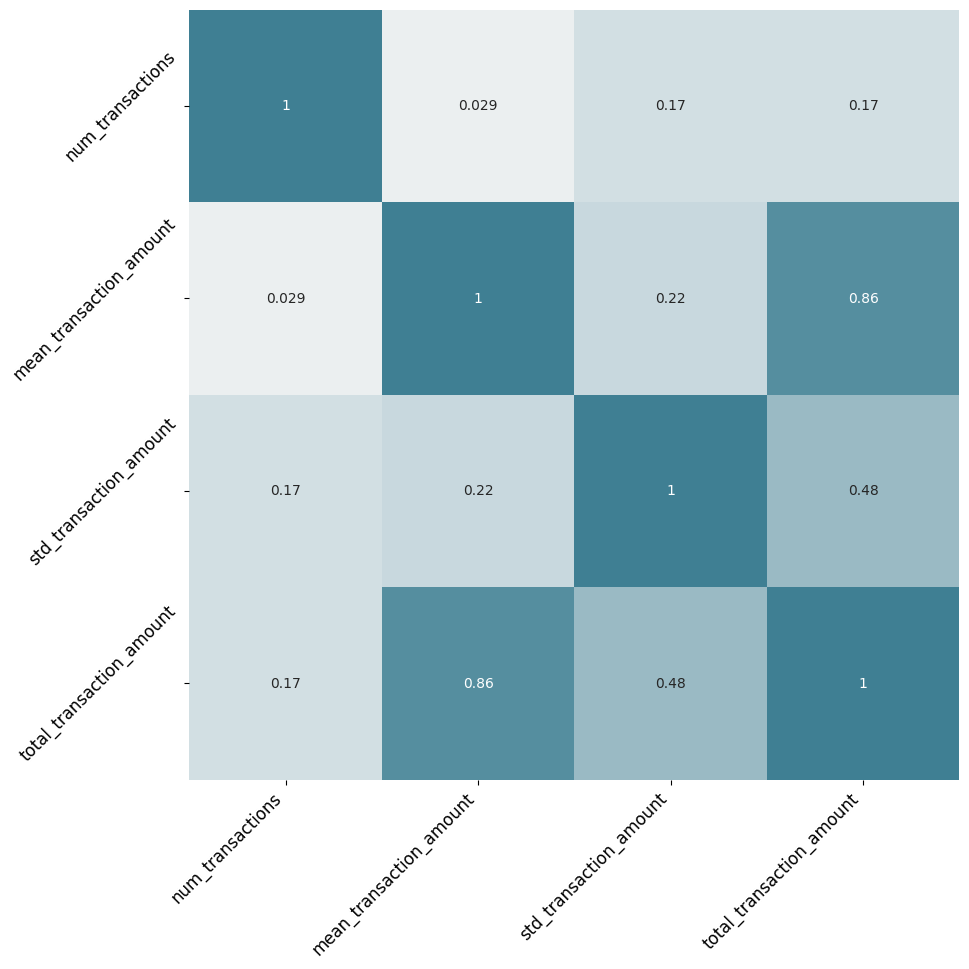

In [ ]:
#Matriz de correlación de datos numéricos
corr_matrix = df_agrupado.select_dtypes(include=['float64', 'int']).corr(method='pearson')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 10},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 12)

Se observa una alta correlación entre el valor total de las transacciones y el valor promedio de cada transacción. Inicialmente se conservarán ambas variables. En caso de evidenciar problemas en el modelado, se eliminará una de las dos variables.

## 3.5. Regla de fraccionamiento transaccional

En los datos se observa que un posible indicador del fraccionamiento transaccional es la alta cantidad de transacciones a una misma cuenta por un mismo usuario durante un día y, además, que la desviación entre los valores de estas transacciones fraccionadas sean cercanas a cero.

En esta sección se hallarán los puntos de ambas variables para considerar un posible fraccionamiento transaccional.

In [ ]:
#Cuenta la cantidad de registros por número total de transacciones
num_transactions_counts=df_agrupado['num_transactions'].value_counts().reset_index()

#Renombra las columnas para mayor claridad
num_transactions_counts.columns=['num_transactions', 'count']

#Calcula el porcentaje de cada valor con respecto al número total de datos
num_transactions_counts['percentage_of_total']=(num_transactions_counts['count'] / len(df)) * 100

#Ordena los valores por 'percentage_of_total'
num_transactions_counts=num_transactions_counts.sort_values(by='percentage_of_total', ascending=False)

# Muestra el resultado
print(num_transactions_counts)

     num_transactions     count  percentage_of_total
0                   1  13479988            78.446242
1                   2   1240258             7.217631
2                   3    183757             1.069366
3                   4     59093             0.343889
4                   5     14779             0.086006
..                ...       ...                  ...
184               194         1             0.000006
182               148         1             0.000006
181               193         1             0.000006
180               178         1             0.000006
191               173         1             0.000006

[192 rows x 3 columns]


In [ ]:
#Cuantiles de la desviación
df_agrupado['std_transaction_amount'].quantile([.1,.2,.3,.4,.5,.6,.7,.8,.9,.925])

0.100    0.000000
0.200    0.000000
0.300    0.000000
0.400    0.000000
0.500    0.000000
0.600    0.000000
0.700    0.000000
0.800    0.000000
0.900    0.000000
0.925    8.406729
Name: std_transaction_amount, dtype: float64

Entre 1 y 4 transacciones en un mismo día por un mismo usuario a una misma cuenta representa el 87% de los datos. En este caso, a partir de 5 transacciones en un mismo día por un mismo usuario a una misma cuenta se considerará como posible fraccionamiento transaccional. Para el caso de la desviación, se tomarán aquellas que estén por debajo del percentil 92.5%.

# 4. MODELADO

## 4.1. Modelo empírico

Con la regla definida en el apartado 3.5, se puede definir que puede existir fraccionamiento transaccional si un usuario en un día hace 5 o mas transferencias a una misma cuenta y la desviación de dichas transferencias es menor o igual al cuartil 25%.

In [ ]:
#Crea una copia de los datos
df_m1=df_agrupado.copy()

In [ ]:
#Calcula el cuartil 25% de la columna 'std_transaction_amount'
quartile_25=df_m1['std_transaction_amount'].quantile(0.925)

#Crea la nueva columna 'alert' con valores 1 o 0 según las condiciones especificadas
df_m1['alert']=(df_m1['num_transactions']>=5) & (df_m1['std_transaction_amount']<=quartile_25)

#Convierte los valores True/False en 1/0 en la columna 'alert'
df_m1['alert']=df_m1['alert'].astype(int)

### 4.1.1. Análisis de resultados

In [ ]:
#Número de registros con alerta
print('Registros con alerta: ', df_m1['alert'].sum())

#Porcentaje de registros sobre el total
print('% de registros con alerta: {:.2f}%'.format((df_m1['alert'].sum()/df_m1['alert'].count())*100))

Registros con alerta:  13337
% de registros con alerta: 0.09%


In [ ]:
#Aisla solo los datos anómalos
df_analisis1=df_m1[df_m1['alert']==1]

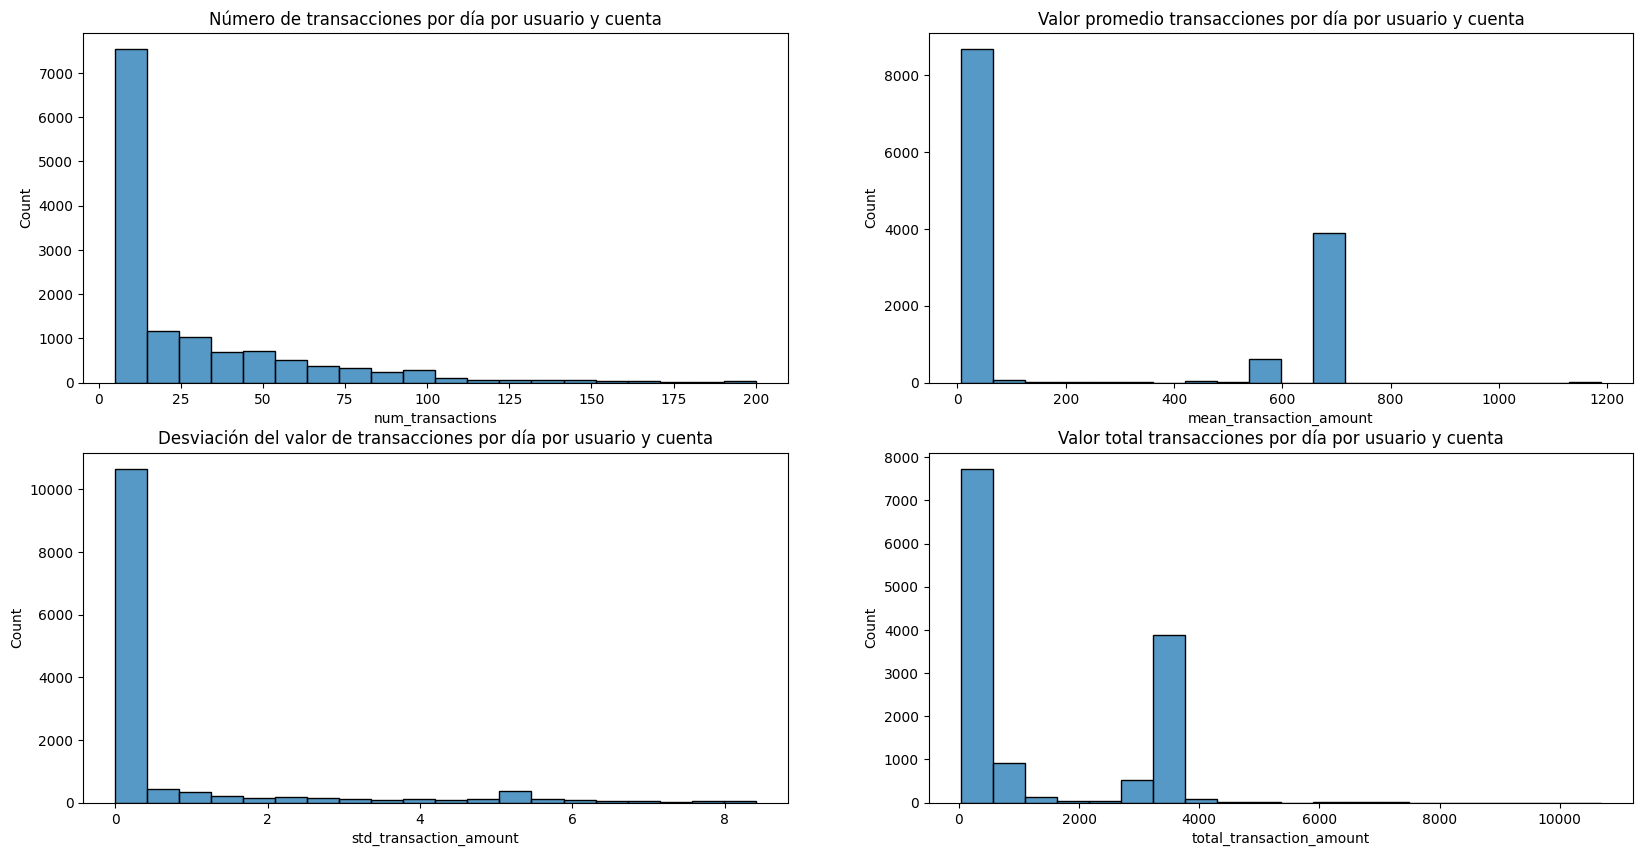

In [ ]:
#Distribución de las variables con valores anómalos
fig, ax=plt.subplots(2,2,figsize=(20,10))

sns.histplot(data=df_analisis1, x='num_transactions', bins=20, ax=ax[0,0])
ax[0,0].set_title('Número de transacciones por día por usuario y cuenta')

sns.histplot(data=df_analisis1, x='mean_transaction_amount', bins=20, ax=ax[0,1])
ax[0,1].set_title('Valor promedio transacciones por día por usuario y cuenta')

sns.histplot(data=df_analisis1, x='std_transaction_amount', bins=20, ax=ax[1,0])
ax[1,0].set_title('Desviación del valor de transacciones por día por usuario y cuenta')

sns.histplot(data=df_analisis1, x='total_transaction_amount', bins=20, ax=ax[1,1])
ax[1,1].set_title('Valor total transacciones por día por usuario y cuenta')

plt.show()

El comportamiento de este método es el esperado ya que los datos se ajustan de acuerdo con la regla que se definió. Los registros considerados como fraccionamiento transaccional, según este método, son los que presentan 5 0 mas transacciones en un mismo día y que la desviación de los valores de dichas transacciones es cercana a 0.

## 4.2. Isolation forest

El modelo de Isolation Forest es una técnica de machine learning utilizada para detectar anomalías o comportamientos inusuales en conjuntos de datos. Trata los datos como árboles en un bosque, y el objetivo es encontrar árboles inusuales o solitarios (anomalías). El modelo Isolation Forest trabaja construyendo muchos árboles de decisión de manera rápida y sencilla. Luego, mide cuántos pasos se necesitan para aislar o separar un punto de datos en un árbol, y si un punto se aísla rápidamente en la mayoría de los árboles, se considera una anomalía. En resumen, es como encontrar un árbol solitario en un bosque, y si es fácil de encontrar, se trata de una anomalía en los datos.

In [ ]:
#Crea una copia de los datos
df_m2=df_agrupado.copy()

In [ ]:
#Se seleccionan las variables a modelar
selected_features=['num_transactions', 'mean_transaction_amount', 'std_transaction_amount', 'total_transaction_amount']
X=df_m2[selected_features]

In [ ]:
#Crea el pipeline de escalado de datos y entrenamiento del modelo
pipeline=Pipeline([
    ('scaler', StandardScaler()),  # Escala los datos
    ('model', IsolationForest(contamination=0.001, random_state=123))  # Entrena el modelo Isolation Forest
])

En el método empírico se indentificó que aproximadamente el 0.1% de los datos se podía considerar como fraccionamiento transaccional, por tal motivo, el parámetro "contamination" que es el que determina la cantidad de datos anómalos se fijó en dicho valor.

In [ ]:
#Entrena el modelo
pipeline.fit(X)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 IsolationForest(contamination=0.001, random_state=123))])

In [ ]:
#Predice anomalías en los datos
df_m2['alert']=pipeline.predict(X)

#Cambia el registro de anomalías, donde 0 es un dato normal y 1 una anomalía
df_m2['alert']=df_m2['alert'].replace({1: 0, -1: 1})

### 4.2.1. Análisis de resultados

In [ ]:
#Número de registros con alerta
print('Registros con alerta: ', df_m2['alert'].sum())

#Porcentaje de registros sobre el total
print('% de registros con alerta: {:.2f}%'.format((df_m2['alert'].sum()/df_m2['alert'].count())*100))

Registros con alerta:  14358
% de registros con alerta: 0.10%


In [ ]:
#Aisla solo los datos anómalos
df_analisis2=df_m2[df_m2['alert']==1]

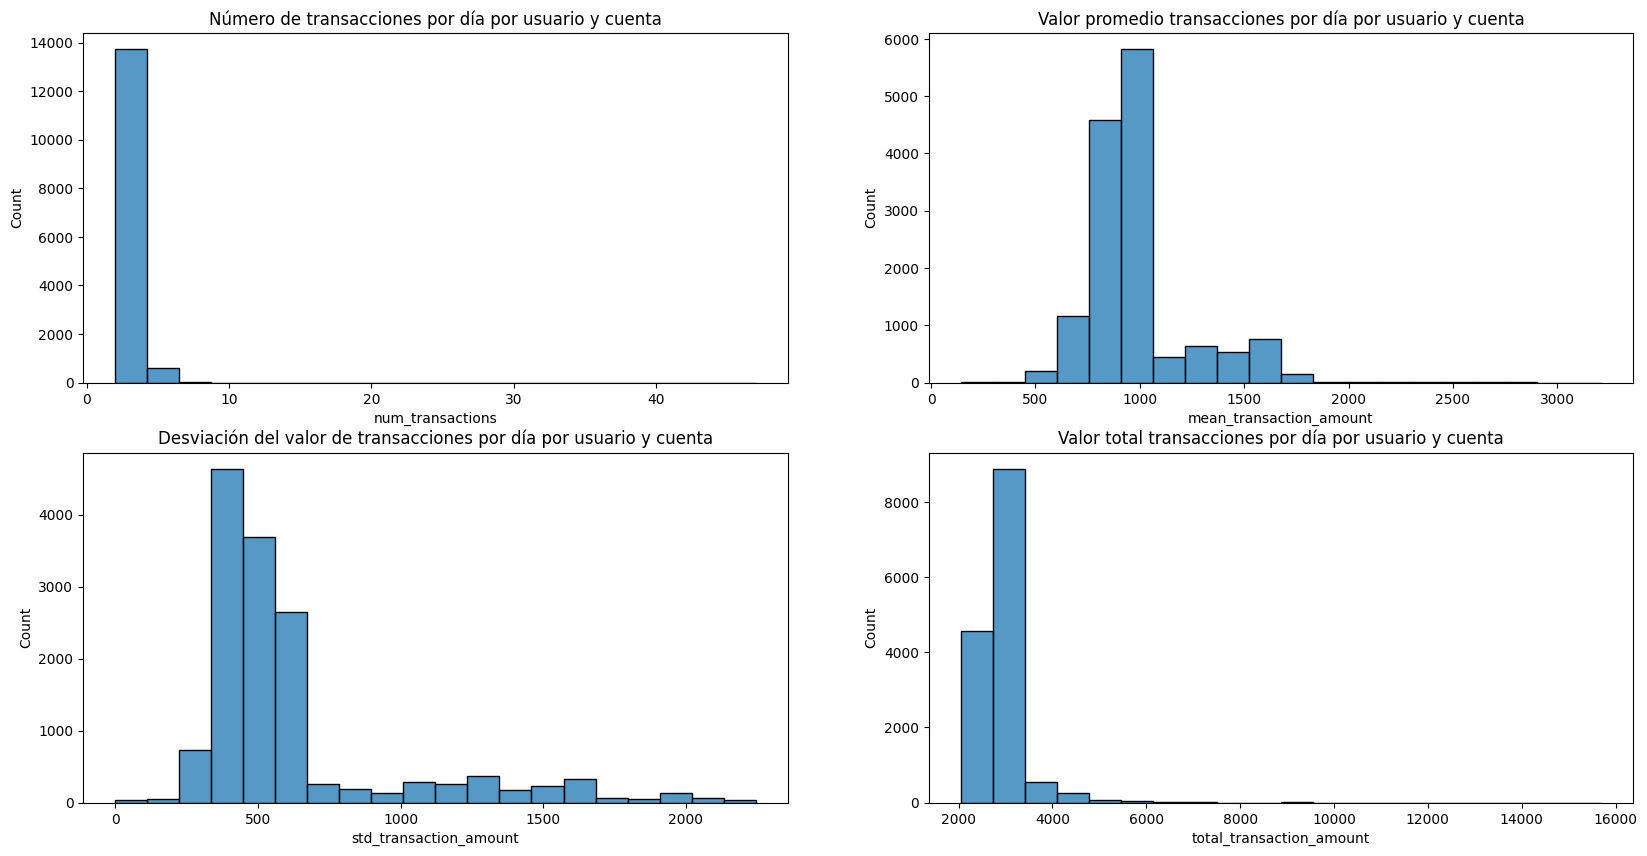

In [ ]:
#Distribución de las variables con valores anómalos
fig, ax=plt.subplots(2,2,figsize=(20,10))

sns.histplot(data=df_analisis2, x='num_transactions', bins=20, ax=ax[0,0])
ax[0,0].set_title('Número de transacciones por día por usuario y cuenta')

sns.histplot(data=df_analisis2, x='mean_transaction_amount', bins=20, ax=ax[0,1])
ax[0,1].set_title('Valor promedio transacciones por día por usuario y cuenta')

sns.histplot(data=df_analisis2, x='std_transaction_amount', bins=20, ax=ax[1,0])
ax[1,0].set_title('Desviación del valor de transacciones por día por usuario y cuenta')

sns.histplot(data=df_analisis2, x='total_transaction_amount', bins=20, ax=ax[1,1])
ax[1,1].set_title('Valor total transacciones por día por usuario y cuenta')

plt.show()

Si bien el modelo de isolation forest detecta como anomalías o fraccionamiento transaccional registros donde el número de transacciones en un día a una misma cuenta desde un mismo usuario sea mayor a 3, no considera como anomalía mas de 50 transacciones en un día. Este modelo rompe el supuesto de que las transacciones con franccionamiento transaccional tienen desviaciones bajas.

## 4.3. Autoencoder

Es una red neuronal que aprende a reconstruir sus entradas y luego evalúa cuán bien puede reconstruir los datos nuevamente. Los registros que tienen una mala reconstrucción se consideran anomalías.

In [ ]:
#Crea una copia de los datos
df_m3=df_agrupado.copy()

In [ ]:
#Se seleccionan las variables a modelar
selected_features=['num_transactions', 'mean_transaction_amount', 'std_transaction_amount', 'total_transaction_amount']
X=df_m3[selected_features]

In [ ]:
#Escala los datos
scaler=StandardScaler()
X=scaler.fit_transform(X)

In [ ]:
#Define la arquitectura del autoencoder

input_layer=Input(shape=(4,))
encoder=Dense(16, activation='relu')(input_layer)
encoder=Dense(8, activation='relu')(encoder)
encoder=Dense(4, activation='relu')(encoder)

decoder=Dense(8, activation='relu')(encoder)
decoder=Dense(16, activation='relu')(decoder)
decoder=Dense(4, activation='sigmoid')(decoder)

autoencoder=Model(inputs=input_layer, outputs=decoder)

In [ ]:
#Compila el modelo
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
#Entrena el modelo
autoencoder.fit(X, X, epochs=10, batch_size=256, shuffle=True, validation_split=0.2)

Epoch 1/10
46842/46842 [==============================] - 166s 3ms/step - loss: 0.7056 - val_loss: 0.5878
Epoch 2/10
46842/46842 [==============================] - 162s 3ms/step - loss: 0.7041 - val_loss: 0.5877
Epoch 3/10
46842/46842 [==============================] - 161s 3ms/step - loss: 0.7041 - val_loss: 0.5877
Epoch 4/10
46842/46842 [==============================] - 162s 3ms/step - loss: 0.7040 - val_loss: 0.5877
Epoch 5/10
46842/46842 [==============================] - 162s 3ms/step - loss: 0.7040 - val_loss: 0.5877
Epoch 6/10
46842/46842 [==============================] - 161s 3ms/step - loss: 0.7040 - val_loss: 0.5877
Epoch 7/10
46842/46842 [==============================] - 162s 3ms/step - loss: 0.7040 - val_loss: 0.5877
Epoch 8/10
46842/46842 [==============================] - 161s 3ms/step - loss: 0.7040 - val_loss: 0.5877
Epoch 9/10
46842/46842 [==============================] - 161s 3ms/step - loss: 0.7040 - val_loss: 0.5877
Epoch 10/10
46842/46842 [=====================

In [ ]:
#Hace las predicciones
reconstructed_data = autoencoder.predict(X)
mse = tf.keras.losses.mean_squared_error(X, reconstructed_data)

468416/468416 [==============================] - 587s 1ms/step


In [ ]:
#Percentiles del error
np.percentile(mse, [10, 20, 30, 40, 50, 60, 70, 80, 90, 92, 95, 99.9])

array([1.32856797e-02, 2.02397462e-02, 5.88971935e-02, 6.91584945e-02,
       1.30629733e-01, 1.63433760e-01, 1.87895671e-01, 2.42426336e-01,
       2.72495091e-01, 3.87506515e-01, 1.15387261e+00, 4.38959618e+01])

Se tomarán como anomalías datos con un error que sea mayor al percentil 99.

In [ ]:
#Se definen los datos que son anomalías
anomalies = mse > np.percentile(mse, [99.9])[0]
df_m3['alert']=anomalies

#Convierte los valores True/False en 1/0 en la columna 'alert'
df_m3['alert']=df_m3['alert'].astype(int)

### 4.3.1. Análisis de resultados

In [ ]:
#Número de registros con alerta
print('Registros con alerta: ', df_m3['alert'].sum())

#Porcentaje de registros sobre el total
print('% de registros con alerta: {:.2f}%'.format((df_m3['alert'].sum()/df_m3['alert'].count())*100))

Registros con alerta:  14956
% de registros con alerta: 0.10%


In [ ]:
#Aisla solo los datos anómalos
df_analisis3=df_m3[df_m3['alert']==1]

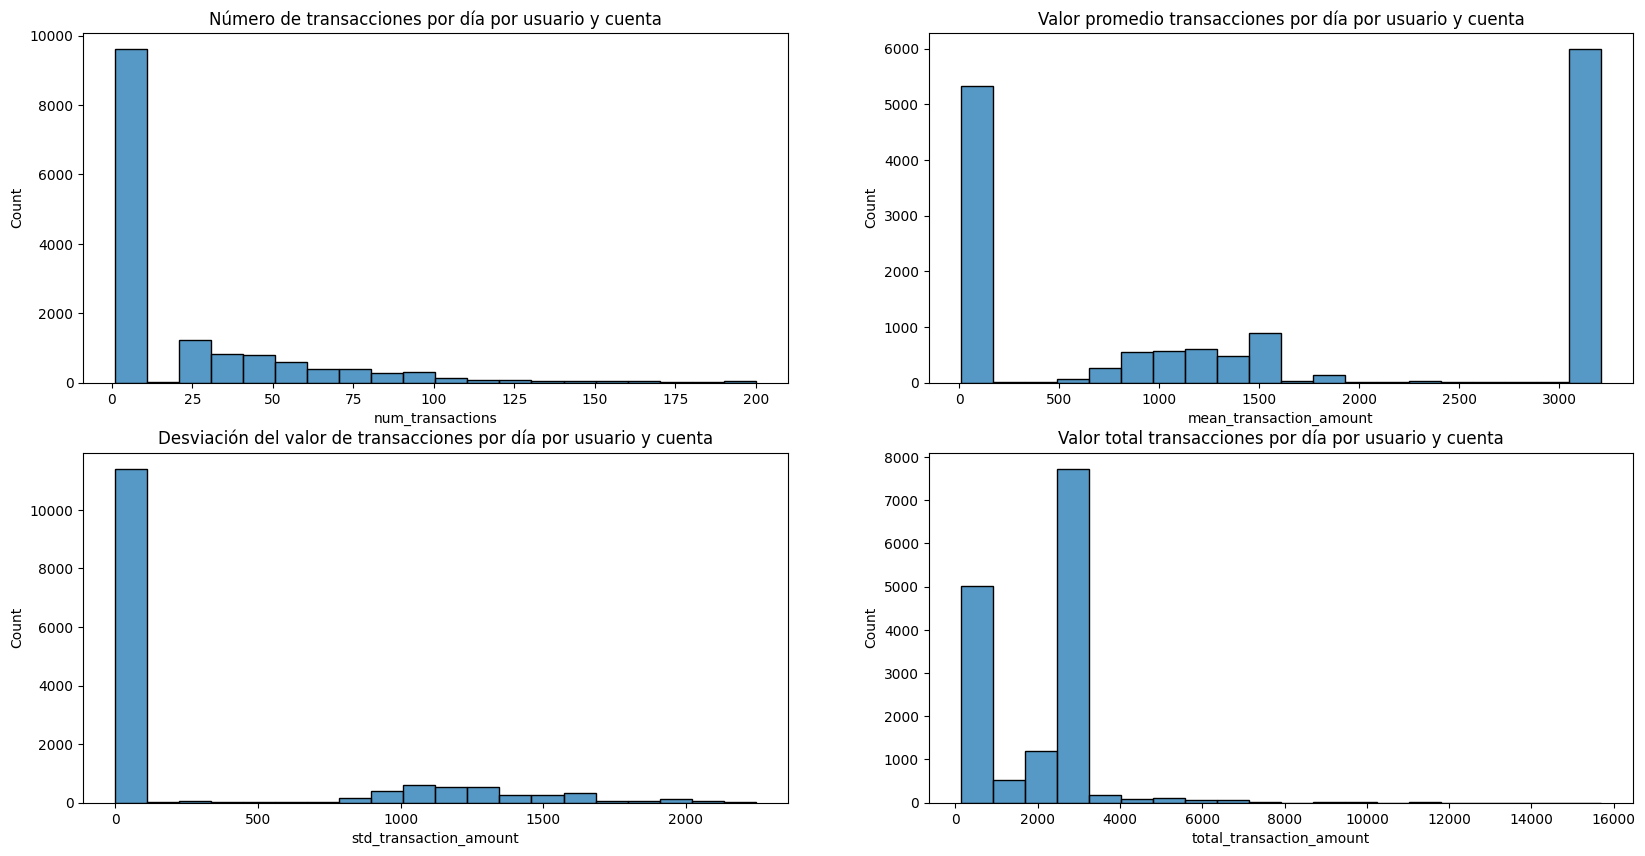

In [ ]:
#Distribución de las variables con valores anómalos
fig, ax=plt.subplots(2,2,figsize=(20,10))

sns.histplot(data=df_analisis3, x='num_transactions', bins=20, ax=ax[0,0])
ax[0,0].set_title('Número de transacciones por día por usuario y cuenta')

sns.histplot(data=df_analisis3, x='mean_transaction_amount', bins=20, ax=ax[0,1])
ax[0,1].set_title('Valor promedio transacciones por día por usuario y cuenta')

sns.histplot(data=df_analisis3, x='std_transaction_amount', bins=20, ax=ax[1,0])
ax[1,0].set_title('Desviación del valor de transacciones por día por usuario y cuenta')

sns.histplot(data=df_analisis3, x='total_transaction_amount', bins=20, ax=ax[1,1])
ax[1,1].set_title('Valor total transacciones por día por usuario y cuenta')

plt.show()

El modelo de autoencoder detecta como anómalos registros con una sola transacción en un día. Este modelo no se ajusta a los hallazgos hechos en el EDA y puede ser útil para detectar otro tipo de anomalías.

# 5. CONCLUSIONES



1.   El análisis exploratorio de datos muestra que cuando se presentan varias transacciones en un mismo día por un mismo usuario a una misma cuenta, se presentan desviaciones bajas, cercanas a cero, entre los valores de cada transacción
2.   Se construyeron 3 modelos para identificar los posibles registros que son fraccionamiento transaccional: uno empírico, un modelo de isolation forest y un modelo de autoencoder usando redes neuronales. El modelo empírico se construyó con base en las observaciones hechas en el análisis de datos, estableciendo como regla para marcar un registro como fraccionamiento cuando este tiene 5 o mas transacciones y la desviación de estas transacciones está por debajo del percentil 92.5%.
3.   Se considera que el modelo que mejor puede detectar el fraccionamiento es el empírico ya que es una regla construída con la observación del comportamiento de los datos. El modelo de isolation forest da unos resultados aceptables al considerar como anómalos registros con mas de 3 transacciones, sin embargo, no considera como anomalía mas de 50 transacciones en un mismo día.



